In [4]:
import pandas as pd
import numpy as np
import pickle as pkl
import tensorflow as tf

import fasttext as ft
from sklearn.metrics.pairwise import cosine_similarity



import sys
sys.path.append('../')
from utils import *

2023-08-11 12:53:13.364376: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-11 12:53:13.930976: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
watches = pd.read_pickle('../../data/user-level-data')
videos = pd.read_pickle('../../data/videos_raw_metadata')

In [6]:
watches_df = dict()

def convert(watch):
    d = dict()
    d['playing'] = watch['playing']['id']
    suggested = []
    for s in watch['suggested']:
        if s != None:
            suggested.append(s['id'])
    d['suggested'] = suggested
    d['selected'] = watch['selected']
    return d

for user in watches:
    watches_df[user] = []
    for watch in watches[user]:
        if watch['playing'] == None:
            continue
        watch = convert(watch)
        watches_df[user].append(watch)

In [42]:
from collections import Counter

all_channels = []

for video in videos:
    video = videos[video]
    channel = video['snippet']['channelTitle']
    all_channels.append(channel)

all_channels = Counter(all_channels)
all_channels = pd.DataFrame.from_dict(all_channels, 'index', columns=['count'])
all_channels = all_channels.sort_values(['count'], ascending=False).head(1000)
# all_channels = list(set(all_channels))
all_channels = list(all_channels.index)

def get_one_hot_channel(channel):
    if channel in all_channels:
        i = all_channels.index(channel)
        one_hot = [0] * len(all_channels)
        one_hot[i] = 1
    else:
        i = 1000
        one_hot = [0] * len(all_channels)
    return one_hot

In [43]:
from collections import Counter


all_topics = []
all_tags = []

for video in videos:
    video = videos[video]
    
    try:
        topics = video['topicDetails']['topicCategories']
        topics = [topic.split('/')[-1].lower() for topic in topics]
    except:
        topics = []

    all_topics += topics
    
    try:
        tags = video['snippet']['tags']
        tags = [tag.lower() for tag in tags]
    except:
        tags = []

    all_tags += tags

all_topics = list(set(all_topics))

atc = Counter(all_tags)
atc = pd.DataFrame.from_dict(atc, 'index', columns=['count'])
atc = atc.sort_values(['count'], ascending=False).head(5000)
all_tags = list(atc.index)

def get_one_hot_vector(topics, tags):
    oh_topics = np.zeros(len(all_topics))
    for topic in topics:
        oh_topics[all_topics.index(topic)] = 1
        
    oh_tags = np.zeros(len(all_tags))
    for tag in tags:
        if tag in all_tags:
            oh_tags[all_tags.index(tag)] = 1
        
    oh = np.concatenate([oh_topics , oh_tags])
    
    return oh


def get_all_vector(video):
    video = videos[video]
    try:
        topics = video['topicDetails']['topicCategories']
        topics = [topic.split('/')[-1].lower() for topic in topics]
    except:
        topics = []

    try:
        tags = video['snippet']['tags']
        tags = [tag.lower() for tag in tags]
    except:
        tags = []

    channel = video['snippet']['channelTitle']


    topics = get_one_hot_vector(topics, tags)
    channel = get_one_hot_channel(channel)

    return np.concatenate([topics, channel])

In [46]:
history = dict()
users = list(watches_df.keys())
data = dict()

for user in users:
    if len(watches_df[user]) < 10:
        continue
    history[user] = watches_df[user][:10]

    for watch in watches_df[user][10:]:
        if watch['selected'] != None:
            if user not in data:
                data[user] = []
            data[user].append(watch)

for user in list(history.keys()):
    if user not in data:
        history.pop(user)

In [47]:
for user in history:
    history[user] = [s['playing'] for s in history[user]]
    history[user] = [get_all_vector(s) for s in history[user]]
    history[user] = np.array(history[user]).mean(axis=0)

In [19]:
topic_vector = dict()
SG, P, SX, H = [], [], [], []
Y = []

topic_vectors = dict()

for user in tqdm(data):
    user_history = history[user]
    user_history = np.concatenate([user_history, [0]])
    for watch in data[user]:
        
        playing = watch['playing']
        selected = watch['selected']
        upnext = watch['suggested'][:15]

        if playing not in videos or selected not in videos or any([s not in videos for s in watch['suggested']]):
            continue
        if len(watch['suggested']) < 15:
            continue


        playing = get_all_vector(watch['playing'])
        playing = np.concatenate([playing, [0]])

        suggesteds = []
        
        for i, s in enumerate(upnext):
            if s not in topic_vectors:
                topic_vectors[s] = get_all_vector(s)
            sv = topic_vectors[s]
            sv = np.concatenate([sv, [i]])
            suggesteds.append(sv)
        
        suggesteds = np.array(suggesteds)
        # suggesteds = np.mean(suggesteds, axis=0)

        for i, s in enumerate(upnext):
            selected = watch['selected']

            if s == selected:
                y = 1
            else:
                y = 0

            sv = topic_vectors[s]

            sv = np.concatenate([sv, [i]])
            SG.append(suggesteds)
            P.append(playing)
            SX.append(sv)
            H.append(user_history)
            Y.append(y)

  0%|          | 0/1266 [00:00<?, ?it/s]

In [10]:
# [SG, P, SX, H, Y] = pkl.load(open('temp-SG_P_SX_H_Y.pkl', 'rb'))


In [22]:
SG = np.array(SG)
P = np.array(P)
SX = np.array(SX)
H = np.array(H)
Y = np.array(Y)

In [23]:
from sklearn.model_selection import train_test_split

SG_train, SG_test, P_train, P_test, SX_train, SX_test, H_train, H_test, Y_train, Y_test = train_test_split(SG, P, SX, H, Y, test_size=0.2, random_state=42)

In [ ]:
pos = Y.sum()
neg = len(Y) - pos
total = neg + pos
w0 = (1 / neg) * (total / 2.0)
w1 = (1 / pos) * (total / 2.0)
class_weights = {0:w0, 1:w1}
class_weights

AttributeError: 'list' object has no attribute 'sum'

In [14]:
# pkl.dump([SG, P, SX, H, Y], open('temp-SG_P_SX_H_Y.pkl', 'wb'))

In [ ]:
from tensorflow import keras
from keras import Model
from keras.models import Sequential
from keras.metrics import AUC, BinaryAccuracy
from keras.layers import Dense, Dropout, Flatten, Concatenate, Input
from tensorflow.keras.optimizers import SGD

In [ ]:
DP = 0.5

suggested_tensor = Input(shape=[15, 5063])
playing_tensor = Input(shape=[5063])
selected_tensor = Input(shape=[5063])
history_tensor = Input(shape=[5063])


sg_dense = Dense(64, activation='relu')(suggested_tensor)
sg_dense = Dropout(DP)(sg_dense)
# sg_dense = Dense(256, activation='relu')(sg_dense)
# sg_dense = Dropout(DP)(sg_dense)
# sg_dense = Dense(64, activation='relu')(sg_dense)
# sg_dense = Dropout(DP)(sg_dense)
sg = Flatten()(sg_dense)

pl_dense = Dense(64, activation='relu')(playing_tensor)
pl_dense = Dropout(DP)(pl_dense)
# pl_dense = Dense(256, activation='relu')(pl_dense)
# pl_dense = Dropout(DP)(pl_dense)
# pl_dense = Dense(64, activation='relu')(pl_dense)
# pl_dense = Dropout(DP)(pl_dense)
pl = Flatten()(pl_dense)

sl_dense = Dense(64, activation='relu')(selected_tensor)
sl_dense = Dropout(DP)(sl_dense)
# sl_dense = Dense(256, activation='relu')(sl_dense)
# sl_dense = Dropout(DP)(sl_dense)
# sl_dense = Dense(64, activation='relu')(sl_dense)
# sl_dense = Dropout(DP)(sl_dense)
sl = Flatten()(sl_dense)

hl_dense = Dense(64, activation='relu')(history_tensor)
hl_dense = Dropout(DP)(hl_dense)
# hl_dense = Dense(256, activation='relu')(hl_dense)
# hl_dense = Dropout(DP)(hl_dense)
# hl_dense = Dense(64, activation='relu')(hl_dense)
# hl_dense = Dropout(DP)(hl_dense)
hl = Flatten()(hl_dense)

merged = Concatenate()([sg, pl, sl, hl])
# x = Dense(1025, activation='relu')(merged)
# x = Dropout(DP)(x)
# x = Dense(256, activation='relu')(merged)
# x = Dropout(DP)(x)
x = Dense(64, activation='relu')(merged)

final = Dense(1, activation='sigmoid')(x)


METRICS = [BinaryAccuracy(name='accuracy'),
           AUC(name='auc'),       
           keras.metrics.AUC(name='prc', curve='PR')]

model = Model(inputs=[suggested_tensor, playing_tensor, selected_tensor, history_tensor], outputs=final)
model.compile(optimizer='adam', loss='binary_focal_crossentropy', metrics=['accuracy', 'AUC'])

2023-08-11 12:35:47.113216: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46692 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:01:00.0, compute capability: 8.6
2023-08-11 12:35:47.113786: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46692 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:81:00.0, compute capability: 8.6


In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 15, 5063)]           0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 5063)]               0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 5063)]               0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 5063)]               0         []                            
                                                                                              

In [18]:
model.fit([SG_train, P_train, SX_train, H_train], Y_train,
            epochs=30,
            batch_size=32,
            validation_split=0.2)

Epoch 1/30


ValueError: in user code:

    File "/home/hsmhabib/.conda/envs/ytbase/lib/python3.9/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/home/hsmhabib/.conda/envs/ytbase/lib/python3.9/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/hsmhabib/.conda/envs/ytbase/lib/python3.9/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/home/hsmhabib/.conda/envs/ytbase/lib/python3.9/site-packages/keras/src/engine/training.py", line 1080, in train_step
        y_pred = self(x, training=True)
    File "/home/hsmhabib/.conda/envs/ytbase/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/hsmhabib/.conda/envs/ytbase/lib/python3.9/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 15, 5063), found shape=(None, 5063)


In [17]:
#f1 score
from sklearn.metrics import classification_report

y_pred_keras = model.predict([SG_test, P_test, SX_test, H_test]).ravel()
y_pred = np.round(y_pred_keras)
print(classification_report(Y_test, y_pred))

1466/1466 [==============================] - 4s 2ms/step
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     43834
           1       0.41      0.05      0.09      3053

    accuracy                           0.93     46887
   macro avg       0.68      0.52      0.53     46887
weighted avg       0.90      0.93      0.91     46887



In [ ]:
y_pred_kes

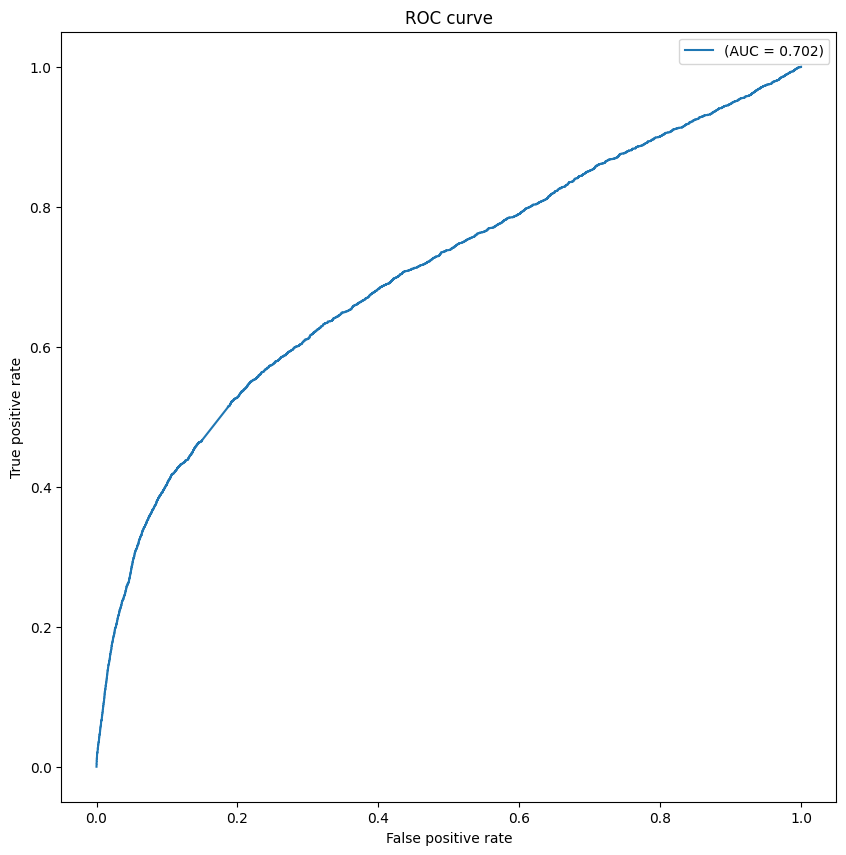

In [18]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# y_pred_keras = model.predict([SG_test, P_test, SX_test, H_test]).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(Y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(figsize=(10,10))
plt.plot(fpr_keras, tpr_keras, label='(AUC = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
